# Download the reports and data

In [168]:
import pandas as pd
import eikon as ek
ek.set_app_key('44272d529e9f430e925fe7017210512be9ade4d6')

In [62]:
def get_companies(country):
    #syntax = 'SCREEN(U(IN(Equity(active,public,private,primary))/*UNV:Public*/), BETWEEN(TR.EmployeesscalYrEndPeriodToPeriodAvg(Period=FY0),0.00,1000.00), IN(TR.HQCountryCode, "'+country+'"))'
    syntax = 'SCREEN(U(IN(Equity(active,public,private,primary))/*UNV:Public*/),  TR.CSRReporting(SDate=0FY, EDate=-10, Period=FY0)==true,  IN(TR.HQCountryCode, "'+country+'"))'
    fields = ['TR.CommonName', 'TR.PrimaryQuote', 'TR.HeadquartersCountry', 'TR.TRBCEconomicSector', 'TR.TRBCBusinessSector', 'TR.TRBCIndustryGroup', 'TR.TRBCIndustry']
    companies, e = ek.get_data(syntax, fields)
    return companies

def get_data(companies):
    fields = ['TR.CommonName', 'TR.HeadquartersCountry', 
              'TR.TRBCEconomicSector', 'TR.TRBCBusinessSector', 'TR.TRBCIndustryGroup', 'TR.TRBCIndustry',
              'TR.TRESGScore', 'TR.TRESGResourceUseScore' , 'TR.TRESGEmissionsScore' 'TR.TRESGInnovationScore',
              'TR.TRESGWorkforceScore', 'TR.TRESGHumanRightsScore', 'TR.TRESGCommunityScore', 
              'TR.TRESGProductResponsibilityScore', 'TR.TRESGManagementScore', 'TR.TRESGShareholdersScore', 
              'TR.TRESGCSRStrategyScore', 'TR.SocialPillarScore', 'TR.GovernancePillarScore', 'TR.EnvironmentPillarScore',
              'TR.EmployeesscalYrEndPeriodToPeriodAvg', 'TR.CSRReportingScope',
              'TR.CSRReportingScope.date', 
              'TR.CSRReportingScope(AddSource=True).esgsourcetitle',
              'TR.CSRReportingScope(AddSource=True).esgsourceurl',
              'TR.CSRReportingScope(AddSource=True).esgupdatedate',
              'TR.CSRReportingScope(AddSource=True).fperiod',
              'TR.ROATotalAssetsPercent', 'TR.ROEPercent', 'TR.TotalReturn']
    params = {'Period':'FY0', 'Frq' : 'FY', 'SDate' : '0', 'EDate' : '-10', 'CH' : 'Fd', 'RH' : 'IN', 'NULL': 'NA'}
    ESGscores, e = ek.get_data(instruments = companies, fields = fields, parameters = params)
    return ESGscores

def get_new_data(companies):
    fields = ['TR.CSRReportingScope',
              'TR.CSRReportingScope(AddSource=True).esgsourcepage',
              'TR.CSRReportingScope.esgsourcetitle',
              'TR.CSRReportingScope.esgsourceurl',
              'TR.CSRReportingScope.fperiod'
              ]
    params = {'Period':'FY0', 'Frq' : 'FY', 'SDate' : '0', 'EDate' : '-10', 'CH' : 'Fd', 'RH' : 'IN', 'NULL': 'NA'}
    ESGscores, e = ek.get_data(instruments = companies, fields = fields, parameters = params)
    return ESGscores

#
#              'TR.CSRReportingScope(AddSource=True).esgsourcepage',
#              'TR.CSRReportingScope(AddSource=True).esgsourcetitle',
#              
#              'TR.CSRReportingScope(AddSource=True).esgfperiod',
#              'TR.CSRReportingScope(AddSource=True).updatedate',

#    'TR.CSRReporting(Period=FY0).date',
#   'TR.CSRReporting(Period=FY0).fperiod',
#    'TR.CSRReporting(Period=FY0).rfperiod',
#    'TR.CSRReporting(Period=FY0).instrument',
#    'TR.CSRReporting(Period=FY0).esgsourcepage',
#    'TR.CSRReporting(Period=FY0).periodenddate',
#    'TR.CSRReporting(Period=FY0).periodisincomplete',
#    'TR.CSRReporting(Period=FY0).esgsourceurl',
#    'TR.CSRReportingScope(AddSource=True).esgsourceurl'

In [53]:
countries = ['AT','BE', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 
             'GR', 'HU', 'IE', 'IT', 'LV', 'LT', 'LU', 'MT', 'NL', 'PL', 'PT', 
             'RO', 'SK', 'SI', 'ES', 'SE']
cntrs = '", "' .join(str(x) for x in countries)
companies = get_companies(cntrs)
companies_list = companies.iloc[:,2].to_list()
companies_list = list(filter(lambda a: a != "", companies_list))

In [100]:
data = get_data(companies_list)
data = data[data['URL']!='']
data.Title = [titl.lower() for titl in data.Title]
data['Date'] = pd.to_datetime(data['Financial Period Absolute'], format = 'FY%Y').dt.year
data = data.reset_index(drop=True)


In [102]:
file_name1 = r'C:\Thesis\Data\Data.pkl'
data.to_pickle(file_name1)

# Download reports

In [1]:
import urllib

import pandas as pd

from io import StringIO

from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser

import pysentiment2 as ps

import os


In [14]:
file_name1 = r'C:\Thesis\Data\Data.pkl'
data = pd.read_pickle(file_name1)

In [2]:
def read_report(report):
    output_string = StringIO()
    with open(report, 'rb') as in_file:
        parser = PDFParser(in_file)
        doc = PDFDocument(parser)
        rsrcmgr = PDFResourceManager()
        device = TextConverter(rsrcmgr, output_string, laparams=LAParams())
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        for page in PDFPage.create_pages(doc):
            interpreter.process_page(page)
    text = output_string.getvalue()
    
    return text

def lm_sentiment(text):
    lm = ps.LM()
    tokens = lm.tokenize(text)
    sentiment = lm.get_score(tokens)
    return sentiment

def hiv_sentiment(text):
    hiv4 = ps.HIV4()
    tokens = hiv4.tokenize(text)
    sentiment = hiv4.get_score(tokens)
    return sentiment

In [56]:
data['filename'] = None
data['downloaded'] = None
data['reports'] = None
data['polarity_LM'] = None
data['subjectivity_LM'] = None
data['polarity_HIV'] = None
data['subjectivity_HIV'] = None

In [3]:
file_name = r'C:\Thesis\Data\DataSent.pkl'
data = pd.read_pickle(file_name)

In [4]:
#Exercise code in steps

step = 100

for n in range(64,80):
    begin = n*step

    file_name = r'C:\Thesis\Data\DataSent.pkl'
    data = pd.read_pickle(file_name)

    for i, url in enumerate(data.URL.iloc[begin:begin+step]):
        link = url
        comp = data.Instrument.iloc[begin+i]
        year = data.Date.iloc[begin+i]
        filename = r'C:\Thesis\Reports\{}.pdf'.format(str(str(begin+i)+comp+str(year)))
        #data.loc[i,'filename']=filename

        if '.pdf' in url:
        
            try: 
                urllib.request.urlretrieve(link, filename)
                data.loc[begin+i,'downloaded']='success'

                try: 
                    text = read_report(filename)

                    score1 = lm_sentiment(text)
                    score2 = hiv_sentiment(text)

                    data.loc[begin+i,'reports']=text
                    data.loc[begin+i,'polarity_LM']=score1['Polarity']
                    data.loc[begin+i,'subjectivity_LM']=score1['Subjectivity']
                    data.loc[begin+i,'polarity_HIV']=score2['Polarity']
                    data.loc[begin+i,'subjectivity_HIV']=score2['Subjectivity']


                except: 
                    data.loc[begin+i,'downloaded']='cannot read file'


                os.remove(filename)

            except: 
                data.loc[begin+i,'downloaded']='failed'
                
        else:
            data.loc[begin+i,'downloaded']='no pdf found'

    data.to_pickle(file_name)

In [5]:
#just to check

i = 623
link = data.URL.iloc[i]
comp = data.Instrument.iloc[i]
year = data.Date.iloc[i]
filename = r'C:\Thesis\Reports\{}.pdf'.format(str(str(i)+comp+str(year)))
urllib.request.urlretrieve(link, filename)
data.loc[i,'downloaded']='success'
text = read_report(filename)
        
score1 = lm_sentiment(text)
score2 = hiv_sentiment(text)


In [31]:
begin=600
step=23
for i, url in enumerate(data.URL.iloc[begin:begin+step]):
    link = url
    comp = data.Instrument.iloc[begin+i]
    year = data.Date.iloc[begin+i]
    filename = r'C:\Thesis\Reports\{}.pdf'.format(str(str(begin+i)+comp+str(year)))
    #data.loc[i,'filename']=filename

    if 'pdf' in url:
        
        try: 
            urllib.request.urlretrieve(link, filename)
            data.loc[begin+i,'downloaded']='success'

            try: 
                text = read_report(filename)

                score1 = lm_sentiment(text)
                score2 = hiv_sentiment(text)

                data.loc[begin+i,'reports']=text
                data.loc[begin+i,'polarity_LM']=score1['Polarity']
                data.loc[begin+i,'subjectivity_LM']=score1['Subjectivity']
                data.loc[begin+i,'polarity_HIV']=score2['Polarity']
                data.loc[begin+i,'subjectivity_HIV']=score2['Subjectivity']


            except: 
                data.loc[begin+i,'downloaded']='cannot read file'


            os.remove(filename)

        except: 
            data.loc[begin+i,'downloaded']='failed'

data.to_pickle(file_name)

In [60]:
# Exercise code at once

for i, url in enumerate(data.URL):
    link = url
    comp = data.Instrument.iloc[i]
    year = data.Date.iloc[i]
    filename = r'C:\Thesis\Reports\{}.pdf'.format(str(str(i)+comp+str(year)))
    #data.loc[i,'filename']=filename
    
    try: 
        urllib.request.urlretrieve(link, filename)
        data.loc[i,'downloaded']='success'
        text = read_report(filename)
        
        score1 = lm_sentiment(text)
        score2 = hiv_sentiment(text)
        
        data.loc[i,'reports']=text
        data.loc[i,'polarity_LM']=score1['Polarity']
        data.loc[i,'subjectivity_LM']=score1['Subjectivity']
        data.loc[i,'polarity_HIV']=score2['Polarity']
        data.loc[i,'subjectivity_HIV']=score2['Subjectivity']
        
        os.remove(filename)

    except:
        data.loc[i,'downloaded']='failed'

## Download daily prices

In [ ]:
import pandas as pd
import eikon as ek
ek.set_app_key('44272d529e9f430e925fe7017210512be9ade4d6')

In [331]:
file_name2 = r'C:\Thesis\Data\DataSent.pkl'
data_sent = pd.read_pickle(file_name2)

In [170]:
companies = data_sent.Instrument.drop_duplicates()

In [171]:
def get_daily_prices(RICs):
    
    one_day = datetime.timedelta(days=1)
    ten_years = datetime.timedelta(days=3650)
    today = datetime.datetime.today()

    daily_prices = pd.DataFrame()

    for company in RICs:

        start_date = datetime.datetime(2013,1,1)

        dp = pd.DataFrame()

        while start_date < today:
            end_date = start_date + ten_years

            try:
                dp = pd.concat([dp, ek.get_timeseries(rics = company, 
                                      start_date = start_date, 
                                      end_date = end_date, 
                                      fields = ['CLOSE'], interval = 'daily', corax = 'adjusted')])
            except:
                pass

            start_date = end_date + one_day

        name = dp.columns.name # get RIC 

        dp = dp.rename(columns ={'CLOSE':name})  # Rename column in DF as RIC of the security

        daily_prices = pd.merge(left = daily_prices, right = dp, how = 'outer', left_index = True, right_index = True)
    
    return daily_prices

In [173]:
daily_prices = get_daily_prices(companies)
file_name3 = r'C:\Thesis\Data\DailyPrices.pkl'
daily_prices.to_pickle(file_name3)

2021-05-22 18:01:40,791 P[12912] [MainThread 6528] Error with RHA.PA^I11: No data available for the requested date range
2021-05-22 18:01:40,794 P[12912] [MainThread 6528] RHA.PA^I11: No data available for the requested date range | 
2021-05-22 18:01:43,736 P[12912] [MainThread 6528] Error with APRR.PA^L12: No data available for the requested date range
2021-05-22 18:01:43,738 P[12912] [MainThread 6528] APRR.PA^L12: No data available for the requested date range | 
2021-05-22 18:01:45,422 P[12912] [MainThread 6528] Error with DUGLY.PK^C16: No data available for the requested date range
2021-05-22 18:01:45,424 P[12912] [MainThread 6528] DUGLY.PK^C16: No data available for the requested date range | 
2021-05-22 18:02:05,152 P[12912] [MainThread 6528] Error with OCEN.AS^B12: No data available for the requested date range
2021-05-22 18:02:05,155 P[12912] [MainThread 6528] OCEN.AS^B12: No data available for the requested date range | 
2021-05-22 18:02:13,927 P[12912] [MainThread 6528] Error

## Get modified dates

In [73]:
import pandas as pd
import requests
import os
import datetime
from dateutil.parser import parse as parsedate

In [333]:
file_name2 = r'C:\Thesis\Data\DataSent.pkl'
data_sent = pd.read_pickle(file_name2)

In [186]:
data_main = data_sent[data_sent.downloaded=='success'].reset_index(drop=True)
data_main = data_main[['Instrument', 'Company Common Name', 'Country of Headquarters',
       'TRBC Economic Sector Name', 'TRBC Business Sector Name',
       'TRBC Industry Group Name', 'TRBC Industry Name', 'ESG Score',
       'Resource Use Score', 'Workforce Score', 'Human Rights Score',
       'Community Score', 'Product Responsibility Score', 'Management Score',
       'Shareholders Score', 'CSR Strategy Score', 'Social Pillar Score',
       'Governance Pillar Score', 'Environmental Pillar Score',
       'Employees, Prd/Prd Avg, FY', 'ESG Reporting Scope', 'Date', 'Title',
       'URL', 'Update Date', 'Financial Period Absolute',
       'ROA Total Assets, Percent', 'Pretax ROE Total Equity %',
       'Total Return', 'downloaded', 'polarity_LM',
       'subjectivity_LM', 'polarity_HIV', 'subjectivity_HIV']]
file_name = r'C:\Thesis\Data\DataMain.pkl'
data_main.to_pickle(file_name)

In [335]:
file_name2 = r'C:\Thesis\Data\DataMain.pkl'
data_main = pd.read_pickle(file_name2)

In [52]:
for i in data_main.index:
    try:
        r = requests.head(data_main.URL[i])
        url_time = r.headers['last-modified']
        data_main.loc[i,'filedate']= pd.to_datetime(url_time).strftime(format = "%Y-%m-%d")
    except:
        try:
            r = requests.get(data_main.URL[i])
            url_time = r.headers['last-modified']
            data_main.loc[i,'filedate']= pd.to_datetime(url_time).strftime(format = "%Y-%m-%d")
        except:
            data_main.loc[i,'filedate']= 'failed'

C:\Users\D\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\Users\D\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname KST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\Users\D\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\Users\D\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTim

In [53]:
file_name = r'C:\Thesis\Data\DataMain.pkl'
data_main.to_pickle(file_name)

## Clean dates

In [89]:
import re

In [342]:
file_name2 = r'C:\Thesis\Data\DataMain.pkl'
data_main = pd.read_pickle(file_name2)

In [133]:
data_main['check date'] = None

In [134]:
for i in data_main.index:
    if (data_main.filedate[i] != 'failed')&(re.findall("\d+", data_main.Title[i]) != []):
        a = (pd.to_datetime(data_main.filedate[i]) - pd.offsets.DateOffset(years = 1)).year
        b = int(re.findall("\d+", data_main.Title[i])[0])
        if a == b:
            data_main.loc[i,'check date'] = 'ok'
        else:
            data_main.loc[i,'check date'] = 'failed'

In [142]:
data_main = data_main[data_main['check date'] == 'ok'].reset_index(drop=True)

In [144]:
file_name = r'C:\Thesis\Data\DataMainCleanDates.pkl'
data_main.to_pickle(file_name)

## Clean data

In [83]:
import pandas as pd

In [344]:
file_name1 = r'C:\Thesis\Data\DataMainCleanDates.pkl'
data_main = pd.read_pickle(file_name1)


In [85]:
data_main = pd.merge(left = data_main.drop(['Company Common Name', 'Country of Headquarters',
       'TRBC Economic Sector Name', 'TRBC Business Sector Name',
       'TRBC Industry Group Name', 'TRBC Industry Name'], axis = 1), right = companies, how = 'left', left_on = 'Instrument', right_on = 'Instrument')

In [91]:
data_main[['polarity_LM', 'subjectivity_LM', 'polarity_HIV', 'subjectivity_HIV']]= data_main[['polarity_LM', 'subjectivity_LM', 'polarity_HIV', 'subjectivity_HIV']].astype('float64')

In [94]:
file_name1 = r'C:\Thesis\Data\DataMainCleanDates.pkl'
data_main.to_pickle(file_name1)

## Calculate abnormal returns

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
from scipy import stats

In [2]:
file_name1 = r'C:\Thesis\Data\DataMainCleanDates.pkl'
data_main = pd.read_pickle(file_name1)

file_name2 = r'C:\Thesis\Data\DailyPrices.pkl'
daily_prices = pd.read_pickle(file_name2)

In [3]:
# USE IF THREE FACTORS MODEL APPLIED
file_name3 = r'C:\Thesis\Data\Europe_3_Factors_Daily.csv'

famafrench = pd.read_csv(file_name3, sep = ',' ,skiprows = 6)
#famafrench.index = pd.to_datetime(famafrench.index, format = "%Y%m%d")
famafrench.iloc[:,0] = pd.to_datetime(famafrench.iloc[:,0], format = "%Y%m%d")
famafrench.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RF']

In [302]:
# USE IF FIVE FACTORS MODEL APPLIED
file_name3 = r'C:\Thesis\Data\Europe_5_Factors_Daily.csv'

famafrench = pd.read_csv(file_name3, sep = ',' ,skiprows = 6)
#famafrench.index = pd.to_datetime(famafrench.index, format = "%Y%m%d")
famafrench.iloc[:,0] = pd.to_datetime(famafrench.iloc[:,0], format = "%Y%m%d")
famafrench.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

In [4]:
daily_returns = daily_prices.pct_change()
data_main = data_main[data_main['filedate'] >= '2013']
data_main['er_5d'] = None

In [5]:
for i in data_main.index:
    comp = data_main.Instrument[i]
    date_file = pd.to_datetime(data_main['filedate'][i])
    prev_start = date_file - pd.offsets.BDay(201)
    prev_end = date_file - pd.offsets.BDay(1)
    next_start = date_file
    next_end = date_file + pd.offsets.BDay(4)

    x = famafrench[(famafrench['Date'] >= prev_start)&(famafrench['Date'] <= prev_end)].set_index('Date')
    y = daily_returns.loc[(daily_returns.index >=prev_start) & (daily_returns.index <=prev_end), comp]
    sample = pd.merge(left = x, right = y, how = 'inner', left_index = True, right_index = True)
    
    model = sm.OLS(sample.iloc[:,4], sample.iloc[:,:3] )
    results = model.fit(cov_type = 'HC0')
    betas = results.params


    x = famafrench[(famafrench['Date'] >= next_start)&(famafrench['Date'] <= next_end)].set_index('Date')
    y = daily_returns.loc[(daily_returns.index >=next_start) & (daily_returns.index <=next_end),comp]
    forecast = pd.merge(left = x, right = y, how = 'inner', left_index = True, right_index = True)
    data_main.loc[i,'er_5d'] = (1 + forecast.iloc[:,4] -(forecast.iloc[:,:3]*betas).sum(axis=1) + forecast.iloc[:,3]).product() - 1 

data_main['er_5d'] = data_main['er_5d'].astype('float64')

In [6]:
data_main['positive'] = 1*(data_main['polarity_LM']>=0)

In [7]:
data_main['Year'] = pd.to_datetime(data_main.filedate).dt.year

In [61]:
data_main.groupby('Year').positive.describe(percentiles=[])['mean'].round(3).to_list()

[0.585, 0.5, 0.71, 0.623, 0.656, 0.549, 0.523, 0.526, 0.635]

In [65]:
data_main.groupby('Year').er_5d.describe(percentiles=[]).drop('50%', axis=1).round(3).to_latex()

'\\begin{tabular}{lrrrrr}\n\\toprule\n{} &  count &   mean &    std &    min &    max \\\\\nYear &        &        &        &        &        \\\\\n\\midrule\n2013 &   53.0 &  0.000 &  0.052 & -0.135 &  0.131 \\\\\n2014 &   98.0 &  0.008 &  0.039 & -0.123 &  0.173 \\\\\n2015 &   62.0 & -0.017 &  0.056 & -0.252 &  0.121 \\\\\n2016 &   61.0 & -0.003 &  0.036 & -0.122 &  0.092 \\\\\n2017 &   90.0 &  0.002 &  0.034 & -0.158 &  0.137 \\\\\n2018 &  162.0 &  0.055 &  0.036 & -0.029 &  0.197 \\\\\n2019 &  331.0 &  0.056 &  0.045 & -0.112 &  0.351 \\\\\n2020 &  407.0 &  0.019 &  0.076 & -0.161 &  0.384 \\\\\n2021 &   63.0 &  0.007 &  0.034 & -0.078 &  0.127 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
data_main.groupby('Year').er_5d.describe(percentiles=[]).drop('50%', axis=1).round(3).to_latex

In [ ]:
data_main.groupby('Year').polarity_LM.describe(percentiles=[]).drop('50%', axis=1).round(3).to_latex()

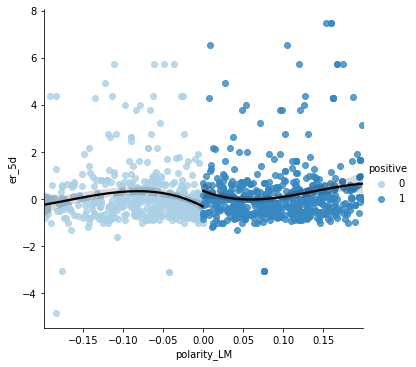

In [313]:
thresh = 0.2
country = 'Spain'
#&(data_main.loc[:,'Country of Headquarters']==country)
subset =  data_main[(data_main.polarity_LM<thresh)&(data_main.polarity_LM>-thresh)]
sns.lmplot(x = 'polarity_LM', y = 'er_5d', hue = 'positive', data = subset, order = 3, palette = 'Blues', line_kws={'color': 'black'})

<AxesSubplot:xlabel='polarity_LM', ylabel='Count'>

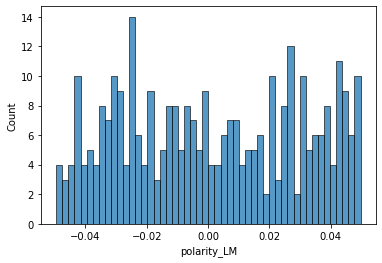

In [228]:
#Check bunching around the threshold
sns.histplot(subset.polarity_LM, bins = 50)

## RDD

In [8]:
from rdd import rdd
from stargazer.stargazer import Stargazer

In [21]:
#bandwidth_opt = rdd.optimal_bandwidth(data_main['er_5d'], data_main['polarity_LM'], cut=0)
#print("Optimal bandwidth:", 0.05)
data_rdd = rdd.truncated_data(data_main, 'polarity_LM', 0.1, cut=0)
data_rdd['polarity_LM2'] = data_rdd['polarity_LM']**2
data_rdd['polarity_LM3'] = data_rdd['polarity_LM']**3

C:\Users\D\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\D\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [22]:
model4 = rdd.rdd(data_rdd, 'polarity_LM', 'er_5d', cut=0).fit()
model5 = rdd.rdd(data_rdd, 'polarity_LM', 'er_5d', cut=0, controls = ['polarity_LM2']).fit()
model6 = rdd.rdd(data_rdd, 'polarity_LM', 'er_5d', cut=0, controls = ['polarity_LM2', 'polarity_LM3']).fit()
#print(model.fit().summary())
stargazer = Stargazer([model1, model2, model3, model4, model5, model6])
stargazer

Estimation Equation:	 er_5d ~ TREATED + polarity_LM
Estimation Equation:	 er_5d ~ TREATED + polarity_LM + polarity_LM2
Estimation Equation:	 er_5d ~ TREATED + polarity_LM + polarity_LM2 + polarity_LM3


In [23]:
stargazer.render_latex()

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lcccccc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{6}{c}{\\textit{Dependent variable:}} \\\n\\cr \\cline{6-7}\n\\\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) \\\\\n\\hline \\\\[-1.8ex]\n Intercept & 0.032$^{***}$ & 0.033$^{***}$ & 0.036$^{***}$ & 0.032$^{***}$ & 0.031$^{***}$ & 0.038$^{***}$ \\\\\n  & (0.007) & (0.008) & (0.009) & (0.005) & (0.006) & (0.007) \\\\\n TREATED & -0.012$^{}$ & -0.013$^{}$ & -0.018$^{}$ & -0.008$^{}$ & -0.008$^{}$ & -0.022$^{*}$ \\\\\n  & (0.012) & (0.012) & (0.016) & (0.010) & (0.010) & (0.013) \\\\\n polarity_LM & 0.043$^{}$ & 0.059$^{}$ & 0.290$^{}$ & 0.014$^{}$ & 0.011$^{}$ & 0.327$^{}$ \\\\\n  & (0.212) & (0.215) & (0.517) & (0.086) & (0.086) & (0.211) \\\\\n polarity_LM2 & & -1.950$^{}$ & -1.752$^{}$ & & 0.358$^{}$ & 0.479$^{}$ \\\\\n  & & (4.206) & (4.230) & & (0.850) & (0.852) \\\\\n polarity_LM3 & & & -105.826$^{}$ & & & -36.765$^{}$ \\\\\n  & & & (215.528)

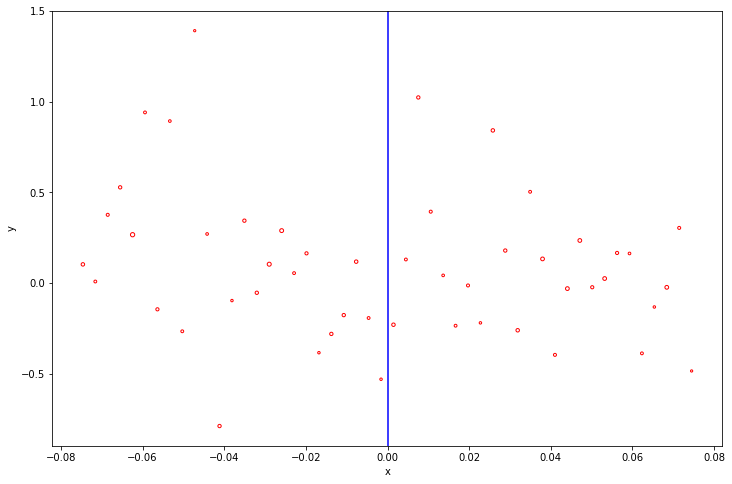

In [312]:
data_binned = rdd.bin_data(data_rdd, 'er_5d', 'polarity_LM', 50)

plt.figure(figsize=(12, 8))
plt.scatter(data_binned['polarity_LM'], data_binned['er_5d'],
    s = data_binned['n_obs'], facecolors='none', edgecolors='r')
plt.axvline(x=0, color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
plt.close()

In [212]:
subset['polarity_LM2'] = subset['polarity_LM']**2
subset['polarity_LM3'] = subset['polarity_LM']**3

formula = 'er_5d ~ polarity_LM +  polarity_LM2 + polarity_LM3'

model1 = ols(formula, data = subset, subset = (data_main['positive']==0))
model2 = ols(formula, data = subset, subset = (data_main['positive']==1))
results1 = model1.fit(cov_type='HC0')
results2 = model2.fit(cov_type='HC0')
results2.params[0] - results1.params[0] 

C:\Users\D\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\D\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


-0.005843025075666204

In [174]:
data_main.dtypes

Instrument                       string
ESG Score                       float64
Resource Use Score              float64
Workforce Score                 float64
Human Rights Score              float64
Community Score                 float64
Product Responsibility Score    float64
Management Score                float64
Shareholders Score              float64
CSR Strategy Score              float64
Social Pillar Score             float64
Governance Pillar Score         float64
Environmental Pillar Score      float64
Employees, Prd/Prd Avg, FY      float64
ESG Reporting Scope             float64
Date                              int64
Title                            object
URL                              string
Update Date                      string
Financial Period Absolute        string
ROA Total Assets, Percent       float64
Pretax ROE Total Equity %       float64
Total Return                     object
downloaded                       object
polarity_LM                     float64


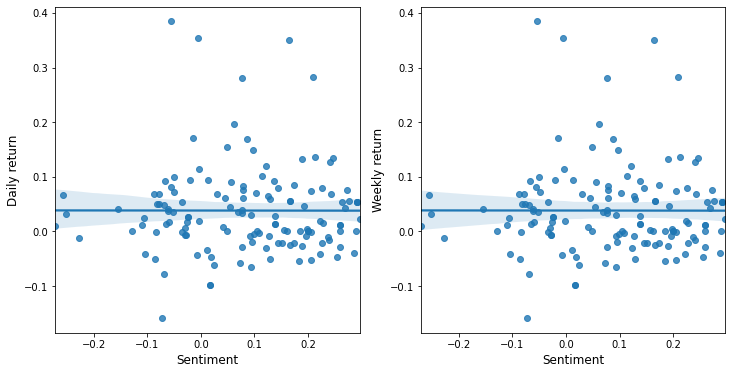

In [120]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

sns.regplot(x = sentiment, y = ret, order = 1, ax = ax[0])
ax[0].set_ylabel('Daily return', fontsize = 12)
ax[0].set_xlabel('Sentiment', fontsize = 12)

sns.regplot(x = sentiment, y = ret, order = 1, ax = ax[1])
ax[1].set_ylabel('Weekly return', fontsize = 12)
ax[1].set_xlabel('Sentiment', fontsize = 12)
plt.show()

# Analysis

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
from scipy import stats

In [3]:
file_name2 = r'C:\Courses\Thesis\Data\DataMain.pkl'
data_main = pd.read_pickle(file_name2)

file_name3 = r'C:\Courses\Thesis\Data\DataReturns.pkl'
data_ret = pd.read_pickle(file_name3)

In [4]:
data_sent = data_main[['Instrument', 'Company Common Name', 'Country of Headquarters',
       'ROA Total Assets, Percent', 'Pretax ROE Total Equity %',
       'Total Return', 'Title','Date','polarity_LM',
       'subjectivity_LM', 'polarity_HIV', 'subjectivity_HIV']]

data_ret = data_ret[['Instrument', 'Company Common Name', 'Country of Headquarters', 'return_d', 'return_w', 'return_2w',
       'return_m', 'return_2m']]

data3 = pd.merge(left = data_sent, right = data_ret, left_index = True, right_index = True, how = 'inner')

subset = data3[(data3.polarity_LM.notna())&(data3.return_d.notna())&((data3.Title.str.contains('sustain'))|(data3.Title.str.contains('respons'))|((data3.Title.str.contains('non-financ'))))]
#&(data_sent.Date==2017)

In [5]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

is_numeric_dtype(subset.polarity_LM)

False

In [12]:
thresh = 0.1
sentiment = subset[(subset.polarity_LM<thresh)&(subset.polarity_LM>-thresh)].polarity_LM*subset[(subset.polarity_LM<thresh)&(subset.polarity_LM>-thresh)].subjectivity_LM
daily_ret = subset[(subset.polarity_LM<thresh)&(subset.polarity_LM>-thresh)].return_d
weekly_ret = subset[(subset.polarity_LM<thresh)&(subset.polarity_LM>-thresh)].return_w
weekly2_ret = subset[(subset.polarity_LM<thresh)&(subset.polarity_LM>-thresh)].return_2w
monthly_ret = subset[(subset.polarity_LM<thresh)&(subset.polarity_LM>-thresh)].return_m
monthly2_ret = subset[(subset.polarity_LM<thresh)&(subset.polarity_LM>-thresh)].return_2m
roa = subset[(subset.polarity_LM<thresh)&(subset.polarity_LM>-thresh)]['ROA Total Assets, Percent']
roe = subset[(subset.polarity_LM<thresh)&(subset.polarity_LM>-thresh)]['Pretax ROE Total Equity %']
totret = subset[(subset.polarity_LM<thresh)&(subset.polarity_LM>-thresh)]['Total Return']

In [16]:
# Run a t-test
print(monthly_ret[sentiment<0].mean(), monthly_ret[sentiment>0].mean())
print(stats.ttest_ind(monthly_ret[sentiment<0], monthly_ret[sentiment>0], equal_var = False))

-0.0005915937501918012 -0.00042506370140413604
Ttest_indResult(statistic=-0.41378301030608505, pvalue=0.6792829916698928)


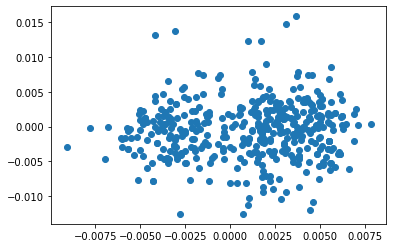

In [17]:
plt.scatter(x = sentiment, y = monthly_ret)

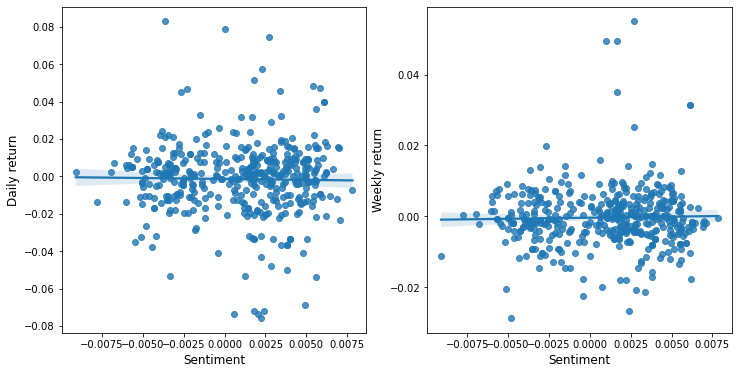

In [25]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

sns.regplot(x = sentiment.astype('float'), y = daily_ret.astype('float'), order = 1, ax = ax[0])
ax[0].set_ylabel('Daily return', fontsize = 12)
ax[0].set_xlabel('Sentiment', fontsize = 12)

sns.regplot(x = sentiment.astype('float'), y = weekly_ret.astype('float'), order = 1, ax = ax[1])
ax[1].set_ylabel('Weekly return', fontsize = 12)
ax[1].set_xlabel('Sentiment', fontsize = 12)
plt.show()

# Regressions

In [197]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
file_name3 = r'C:\Thesis\Data\MergedData.pkl'
data3 = pd.read_pickle(file_name3)

In [210]:
regress = data3.iloc[:,[0,1,2,-1,-2,-12]]
regress.columns = ['ROA', 'ROE', 'Return', 'Small', 'Report', 'Employees']

In [ ]:
regress['Empl2']=regress.Employees**2
regress['Empl3']=regress.Employees**3

In [223]:
formula = 'ROE ~ Report + Small + Small*Report + ROA'

model1 = ols(formula, regress)
results1 = model1.fit(cov_type='HC0')
print(results1.summary()

                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     1.732
Date:                Fri, 30 Apr 2021   Prob (F-statistic):              0.142
Time:                        19:44:13   Log-Likelihood:                -2307.2
No. Observations:                 385   AIC:                             4624.
Df Residuals:                     380   BIC:                             4644.
Df Model:                           4                                         
Covariance Type:                  HC0                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -41.2817     32.412     -1.274   